In [29]:
using Revise, DelimitedFiles

In [34]:
using Pkg
Pkg.activate(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl")

  Activating environment at `~/GIT/susie-glmm/SuSiEGLMM.jl/Project.toml`


In [66]:
@__DIR__

"/Users/jeankim/GIT/susie-glmm/SuSiEGLMM.jl/test"

In [53]:
using Statistics, Distributions, StatsBase, Random, LinearAlgebra, Distributed,GLM

In [64]:
using SuSiEGLMM

In [37]:
#genotype matrix and impute missing values
@time geno=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/ascertained_pop_genotype_12_10.txt";header=true);

X = geno[1][:,6:end]

for j =axes(X,2)
    idx = findall(X[:,j].=="NA")
    X[idx,j].= missing
    X[idx,j] .= mean(skipmissing(X[:,j]))
end

  0.624938 seconds (5.98 M allocations: 209.878 MiB, 14.15% gc time, 15.12% compilation time)


In [38]:
# pedgree grm and grm
K=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm_ped.txt"); #518
K0=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm.txt");
K0=Symmetric(K0);K0=convert(Matrix{Float64}, K0);

In [39]:
Seed(124)

In [41]:
X1= (X.-mean(X,dims=2))./std(X,dims=2)
n,p = size(X1)
L=1; B=1;
tol=1e-4
b_true=zeros(p);
b_1s=zeros(B); 

# Ts=zeros(p,B);Ts1=zeros(p,B);

In [42]:
τ2=0.1;

# res0=[]; res1=[]

# K=Matrix(1.0I,n,n)
T,S = svdK(K;LOCO=false)
# T,S = svdK(K0;LOCO=false)

([1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

## GLMM (no integration out, corrected version)

In [55]:
# for j = 1:B
    b_true[1]= randn(1)[1] 
#     b_1s[j] = b_true[1]   
   
#     X=randn(n,p)
    g=rand(MvNormal(τ2*K)) #pedigree grm
    # g=rand(MvNormal(τ2*K0)) #grm
    
    #generating binary outcome
    Y= logistic.(g) .>rand(n); Y=convert(Vector{Float64},Y);
    Y1=logistic.(X1*b_true+g) .>rand(n);  Y1=convert(Vector{Float64},Y1);
       
    X₀=ones(n,1)
   
   # transforming data         
     Xt, Xt₀, y0 = SuSiEGLMM.rotate(Y,X1,X₀,T)   
       y1= SuSiEGLMM.rotateY(Y1,T)

#initialization
    τ² =2.0.^[-10:0.5:2.5;]
  

26-element Vector{Float64}:
 0.0009765625
 0.0013810679320049757
 0.001953125
 0.0027621358640099515
 0.00390625
 0.005524271728019903
 0.0078125
 0.011048543456039806
 0.015625
 0.02209708691207961
 0.03125
 0.04419417382415922
 0.0625
 0.08838834764831845
 0.125
 0.1767766952966369
 0.25
 0.3535533905932738
 0.5
 0.7071067811865476
 1.0
 1.4142135623730951
 2.0
 2.8284271247461903
 4.0
 5.656854249492381

In [65]:
b_true[1]

1.4459420924929385

In [59]:
#     for j in eachindex(τ²)
#      f=open(joinpath(@__DIR__,"glmm_est_$(τ²[j]).txt"),"w")
      
#         β0 = glm(X₀,Y,Binomial()) |> coef
#         ξ0 =sqrt.(getXy('N',Xt₀,β0).^2+ τ²[j]*S)
#         res0= emGLMM(y0,Xt₀,S,τ²[j],ξ0;tol=tol) #H0
#     end

In [68]:
glm(X₀,Y1,Binomial()) |> coef #initial β

1-element Vector{Float64}:
 -0.027834798993443172

In [67]:
    for j in eachindex(τ²)
   
        β = glm(X₀,Y1,Binomial()) |> coef
        ξ =sqrt.(SuSiEGLMM.getXy('N',Xt₀,β).^2+ τ²[j]*S)

        
        res1= emGLMM(y1,Xt₀,S,τ²[j],ξ;tol=tol) #H1 
           out=readdlm(joinpath(@__DIR__,"glmm_est.txt"))
#            writedlm("glmm_est_$(τ²[j]).txt",out)
            writedlm("glmm_est_$(τ²[j])_grm.txt",out)
#         T0= computeT(res0,y0,Xt₀,Xt)
#         T1= computeT(res1,y1,Xt₀,Xt)
       
    end
        
#printing out # of iterations per case     

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
384
604
720
782
817
836
848
855
860
863
866


### Plots of results when using pedigree K 

In [84]:
#track τ² and the corresponding ELBO for early convergence (max # of iterations: 2)
for j=1:8
println(readdlm("glmm_est_$(τ²[2j-1]).txt")[:,[2, end]])
end

[0.0009765624304588693 -599.6043354131515; 0.0009765623609352599 -599.6043354131509]
[0.0019531245670110129 -599.6043583009778; 0.0019531241341621557 -599.604358300966]
[0.0039062470319848734 -599.6044339337442; 0.003906244065091971 -599.6044339335995]
[0.007812478279908589 -599.604704247401; 0.007812456568869824 -599.6047042454577]
[0.015624834977952487 -599.6057180387395; 0.015624670031267475 -599.6057180107024]
[0.03124872491680569 -599.6096142761623; 0.03124745053691493 -599.6096138577273]
[0.06249013747764906 -599.6246929562564; 0.06248028374636911 -599.6246866991544]
[0.12492484169009832 -599.6825444506499; 0.12484984569336556 -599.682453678602]


In [ ]:
using Plots

In [93]:
#pick two cases
tau16=readdlm("glmm_est_$(τ²[16]).txt")[:,[2, end]]
tau=readdlm("glmm_est_$(τ²[end]).txt")[:,[2, end]]

865×2 Matrix{Float64}:
 4.87141   -635.803
 4.25446   -630.257
 3.76394   -625.83
 3.36881   -622.275
 3.0463    -619.396
 2.77966   -617.044
 2.55651   -615.103
 2.36764   -613.487
 2.2061    -612.127
 2.06661   -610.974
 1.9451    -609.987
 1.83842   -609.137
 1.74406   -608.398
 ⋮         
 0.12888   -599.687
 0.128798  -599.687
 0.128716  -599.687
 0.128634  -599.687
 0.128553  -599.687
 0.128471  -599.687
 0.12839   -599.687
 0.128308  -599.687
 0.128227  -599.687
 0.128146  -599.686
 0.128066  -599.686
 0.127985  -599.686

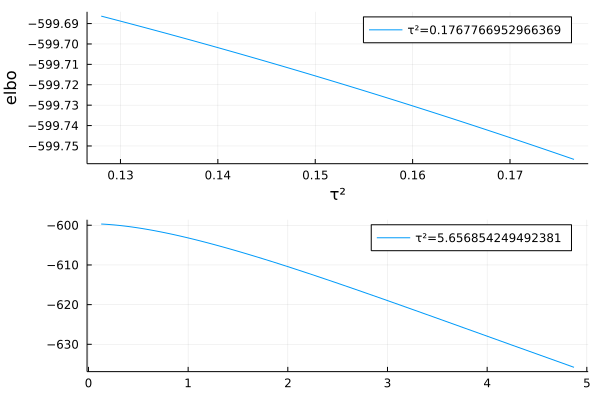

In [97]:
ll=@layout[a ;b]
p1=plot(tau16[:,1],tau16[:,2],label="τ²=$(τ²[16])", xlab="τ²", ylab="elbo")
p2=plot(tau[:,1],tau[:,2],label="τ²=$(τ²[end])")
plot(p1,p2,layout=ll)

## GLMM (integration out)

In [70]:


# for j=1:B
#     Xt, Xt₀, yt,init01= initialization(Y,X,ones(n,1),Matrix(1.0I,n,n),ones(n);tol=1e-4)
#     T1= computeT(init01,yt,Xt₀,Xt)
    
         Σ0= 2(cov(Xt₀)+I) # avoid sigularity when only with intercept
     for j in eachindex(τ²)

        sig0=SuSiEGLMM.getXX('N',Σ0,'T',Xt₀)
        β̂0=SuSiEGLMM.getXy('N',sig0,y1)
        ξ0 =sqrt.(SuSiEGLMM.getXy('N',Xt₀,β̂0 ).^2+ Diagonal(SuSiEGLMM.getXX('N',Xt₀,'N',sig0).+τ²[j]*S)*ones(n))
    

        init= SuSiEGLMM.init(y1,Xt₀,S,ξ0,τ²[j],Σ0;tol=tol)
        out1=readdlm(joinpath(@__DIR__,"est_elbocomp.txt"))
#         writedlm("est_elbocomp_$(τ²[j]).txt",out1)
        writedlm("est_elbocomp_$(τ²[j])_grm.txt",out1)
    end
    
#      init1=[init1;init01]
# init1=[init1;init01]
#       Ts1[:,j]=T1;
# end

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
348
579
697
759
791
810
820
827
831
834
836


In [73]:
Σ0;sig0=SuSiEGLMM.getXX('N',Σ0,'T',Xt₀);
        β̂0=SuSiEGLMM.getXy('N',sig0,y1)

1-element Vector{Float64}:
 -7.0

In [99]:
#track τ² and the corresponding elbo for pedigree K
# early convergence up to initial values close to the true one (max # of iterations: 4)
for j=1:8
display(readdlm("est_elbocomp_$(τ²[2j-1]).txt")[:,[1, end]])
end

4×2 Matrix{Float64}:
 0.000976734  -603.98
 0.000976735  -602.916
 0.000976736  -602.916
 0.000976737  -602.916

4×2 Matrix{Float64}:
 0.00195381  -603.979
 0.00195382  -602.916
 0.00195382  -602.916
 0.00195382  -602.916

4×2 Matrix{Float64}:
 0.003909    -603.979
 0.00390901  -602.916
 0.00390902  -602.916
 0.00390903  -602.916

4×2 Matrix{Float64}:
 0.00782348  -603.978
 0.00782354  -602.916
 0.00782356  -602.916
 0.00782358  -602.916

4×2 Matrix{Float64}:
 0.0156689  -603.977
 0.015669   -602.915
 0.015669   -602.915
 0.015669   -602.915

4×2 Matrix{Float64}:
 0.0314251  -603.976
 0.031425   -602.917
 0.0314244  -602.917
 0.0314237  -602.917

4×2 Matrix{Float64}:
 0.0631967  -603.982
 0.0631915  -602.927
 0.0631839  -602.927
 0.0631763  -602.927

4×2 Matrix{Float64}:
 0.127759  -604.024
 0.127699  -602.978
 0.127629  -602.978
 0.12756   -602.978

In [106]:
t16=readdlm("est_elbocomp_$(τ²[16]).txt")[:,[1,end]]
# tm=readdlm("est_elbocomp_$(τ²[end]).txt")[:,[1,end]]


347×2 Matrix{Float64}:
 0.182249  -604.089
 0.182065  -603.049
 0.181862  -603.049
 0.18166   -603.049
 0.181459  -603.048
 0.181259  -603.048
 0.181059  -603.048
 0.18086   -603.047
 0.180661  -603.047
 0.180463  -603.047
 0.180266  -603.046
 0.180069  -603.046
 0.179873  -603.046
 ⋮         
 0.13783   -602.989
 0.137742  -602.989
 0.137654  -602.989
 0.137567  -602.989
 0.13748   -602.989
 0.137392  -602.989
 0.137305  -602.988
 0.137219  -602.988
 0.137132  -602.988
 0.137045  -602.988
 0.136959  -602.988
 0.136873  -602.988

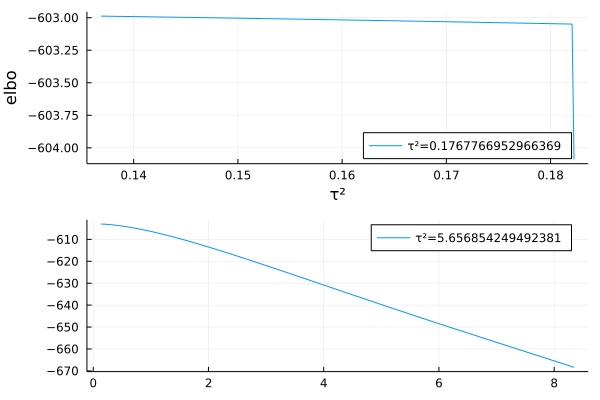

In [108]:
ll=@layout[a ;b]
p3=plot(t16[:,1],t16[:,2],label="τ²=$(τ²[16])", xlab="τ²", ylab="elbo",legend=:bottomright)
p4=plot(tm[:,1],tm[:,2],label="τ²=$(τ²[end])")
plot(p3,p4,layout=ll)